# Load Model and Predict output here 

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [39]:
import tensorflow as tf

# load the .tflite model
interpreter = tf.lite.Interpreter(model_path="../models/model.tflite")

# get the list of available signatures
found_signatures = list(interpreter.get_signature_list().keys())
print("Signatures:", found_signatures)

# get the callable for the default signature
prediction_fn = interpreter.get_signature_runner("serving_default")


Signatures: ['serving_default']


In [40]:
import pandas as pd

train = pd.read_csv('../asl-signs/train.csv')
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

pq_file = '../app/output.parquet'
xyz_np = load_relevant_data_subset(pq_file)

prediction = prediction_fn(inputs=xyz_np)
sign = prediction['outputs']
sign

array([-3.7589940e-01, -1.5474733e+00,  6.6166592e-01,  1.8470358e+00,
       -3.5705179e-01, -6.9505018e-01,  7.2990191e-01,  2.1613778e-01,
       -5.4949433e-01,  1.8358614e-02, -6.8398774e-01, -3.7385884e-01,
       -8.1136662e-01, -1.1138955e+00,  1.4066228e+00, -1.1151645e+00,
        2.0982641e-01, -1.3691103e+00, -8.6283886e-01,  6.1693633e-01,
       -6.1894560e-01, -8.2709295e-01, -3.4060484e-01,  3.8740304e+00,
        1.1261418e+00,  6.9196415e-01, -3.3378357e-01, -1.2444379e+00,
       -4.5223105e-01,  1.7407601e-01, -1.3423261e-01, -1.3184862e+00,
       -1.8853841e+00, -1.3292085e+00, -1.5687710e-01, -9.6923697e-01,
       -4.3209258e-01,  9.8311728e-01,  1.0890752e-01,  2.7658832e-01,
       -1.1869217e+00,  3.8447028e-01, -5.3169448e-02, -4.8268610e-01,
        4.6916395e-01, -4.5200723e-01, -4.1432387e-01,  4.4760437e+00,
        6.3739890e-01, -1.5744489e+00, -1.1408005e+00, -1.2538579e-01,
       -3.5999838e-01,  5.5309451e-01, -1.4696450e+00, -1.1950774e+00,
      

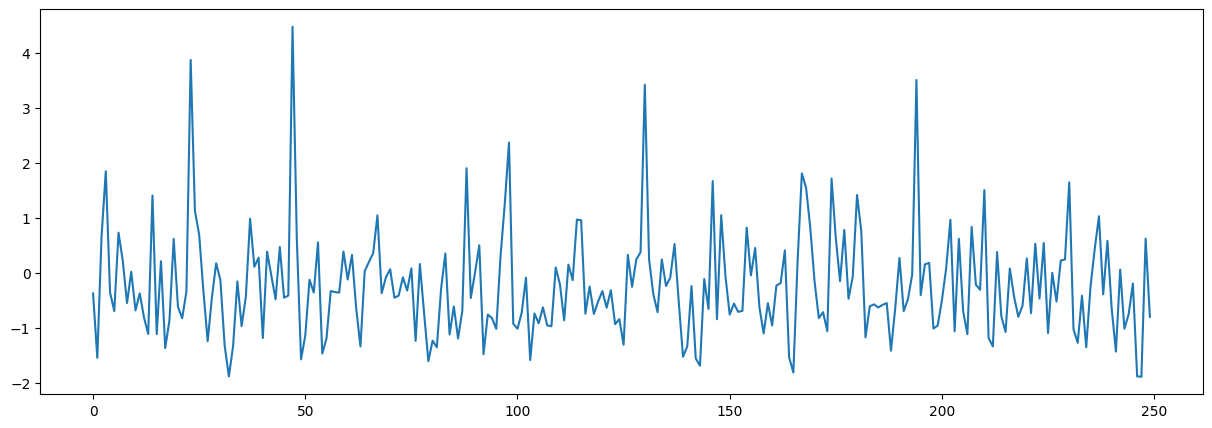

In [41]:
pd.Series(prediction['outputs']).plot(figsize=(15,5))
plt.show()

In [42]:
import pandas as pd
import numpy as np

# sign = prediction['outputs']   # numpy array of probabilities
# ORD2SIGN = {0: 'again', 1: 'all', ...}

sign = np.array(sign)

# build dataframe for *all* predictions

df = pd.DataFrame({
    'Predicted sign': [ORD2SIGN[i] for i in range(len(sign))],
    'Confidence': [float(x) for x in sign],
    'Index': list(range(len(sign)))
})

# sort by confidence descending (optional but helpful)
df = df.sort_values(by='Confidence', ascending=False).reset_index(drop=True)

# round for readability
df['Confidence'] = df['Confidence'].round(4)

print(df.to_string(index=False))


Predicted sign  Confidence  Index
        closet      4.4760     47
          bird      3.8740     23
          shhh      3.5074    194
          lamp      3.4213    130
         goose      2.3704     98
           for      1.9036     88
           all      1.8470      3
           pen      1.8080    167
        police      1.7152    174
          moon      1.6693    146
            up      1.6458    230
        pencil      1.5451    168
           sun      1.5054    210
        puzzle      1.4164    180
       balloon      1.4066     14
            go      1.2485     97
         black      1.1261     24
         mouse      1.0478    148
          duck      1.0456     67
         where      1.0288    237
        carrot      0.9831     37
           hen      0.9684    114
         snack      0.9653    202
       hesheit      0.9561    115
         store      0.8364    207
         noisy      0.8213    154
         penny      0.8040    169
       pretend      0.7801    177
         quiet

In [43]:
import numpy as np
import json

# Assuming:
# sign = np.array(prediction['outputs'])
# ORD2SIGN = {0: 'again', 1: 'all', ...}

TOP_K = 10
top_indices = np.argsort(sign)[::-1][:TOP_K]

payload = [
    {"sign": ORD2SIGN[i], "conf": round(float(sign[i]), 4), "idx": int(i)}
    for i in top_indices
]

# Example: send as JSON string (to your other backend)
json_payload = json.dumps(payload)
print(json_payload)


[{"sign": "closet", "conf": 4.476, "idx": 47}, {"sign": "bird", "conf": 3.874, "idx": 23}, {"sign": "shhh", "conf": 3.5074, "idx": 194}, {"sign": "lamp", "conf": 3.4213, "idx": 130}, {"sign": "goose", "conf": 2.3704, "idx": 98}, {"sign": "for", "conf": 1.9036, "idx": 88}, {"sign": "all", "conf": 1.847, "idx": 3}, {"sign": "pen", "conf": 1.808, "idx": 167}, {"sign": "police", "conf": 1.7152, "idx": 174}, {"sign": "moon", "conf": 1.6693, "idx": 146}]
